In [1]:
# Standard Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Utility for displaying ImageNet labels
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions

# Setting matplotlib display preferences
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['axes.grid'] = False
print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.20.0


In [2]:
# Load the MobileNetV2 model pre-trained on ImageNet
victim_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
victim_model.trainable = False

# Define the loss function we want to MAXIMIZE during the attack (Categorical Cross-Entropy)
loss_object = tf.keras.losses.CategoricalCrossentropy()

print("Victim model (MobileNetV2) loaded successfully.")

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Victim model (MobileNetV2) loaded successfully.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
Baseline Prediction: Labrador_retriever (0.41 confidence)


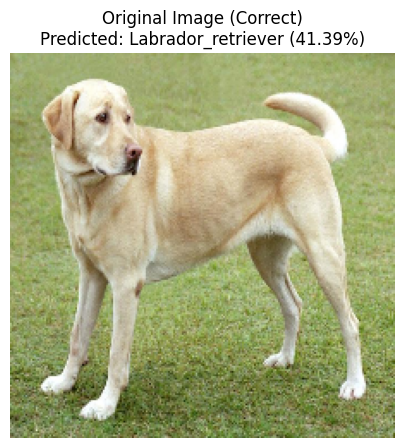

In [5]:
# Image Loading and Baseline Prediction

import requests
from PIL import Image
from io import BytesIO

def preprocess_and_load(image_url):
  """Loads, resizes (224x224), and normalizes the image for MobileNetV2 input (-1 to 1)."""
  try:
      # Download image content
      img_data = requests.get(image_url).content
      img = Image.open(BytesIO(img_data)).convert('RGB')
  except Exception as e:
      print(f"Failed to download image from URL. Error: {e}")
      return tf.zeros((1, 224, 224, 3)) 

  image = tf.convert_to_tensor(np.array(img), dtype=tf.float32)
  image = tf.image.resize(image, (224, 224))
  
  # Normalize the image according to MobileNetV2 standards
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  
  image = image[tf.newaxis, ...]
  return image

image_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
original_image = preprocess_and_load(image_url)

predictions = victim_model.predict(original_image)


if hasattr(predictions, 'numpy'):
    predictions_array = predictions.numpy()
else:
    predictions_array = predictions

# Decode the predictions
decoded_predictions = decode_predictions(predictions_array)

true_label_id = np.argmax(predictions_array[0])
true_label = decoded_predictions[0][0][1]
true_confidence = decoded_predictions[0][0][2]

print(f"Baseline Prediction: {true_label} ({true_confidence:.2f} confidence)")

original_label = tf.one_hot(true_label_id, predictions.shape[-1])
original_label = tf.reshape(original_label, (1, predictions.shape[-1]))

# Display the original image
plt.figure(figsize=(5, 5))
# Rescale to 0-1 range for display
display_image = original_image[0] * 0.5 + 0.5 
plt.imshow(display_image) 
plt.title(f"Original Image (Correct)\nPredicted: {true_label} ({true_confidence*100:.2f}%)")
plt.axis('off')
plt.show()

In [6]:
# Implement the FGSM Attack Function

def create_adversarial_pattern(input_image, input_label):
 
    input_image = tf.cast(input_image, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(input_image)
        
        #  Forward Pass
        prediction = victim_model(input_image)
        
        # Compute Loss J(theta, x, y)
        loss = loss_object(input_label, prediction)

    #  Get the Gradients (nabla_x J)
    gradient = tape.gradient(loss, input_image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


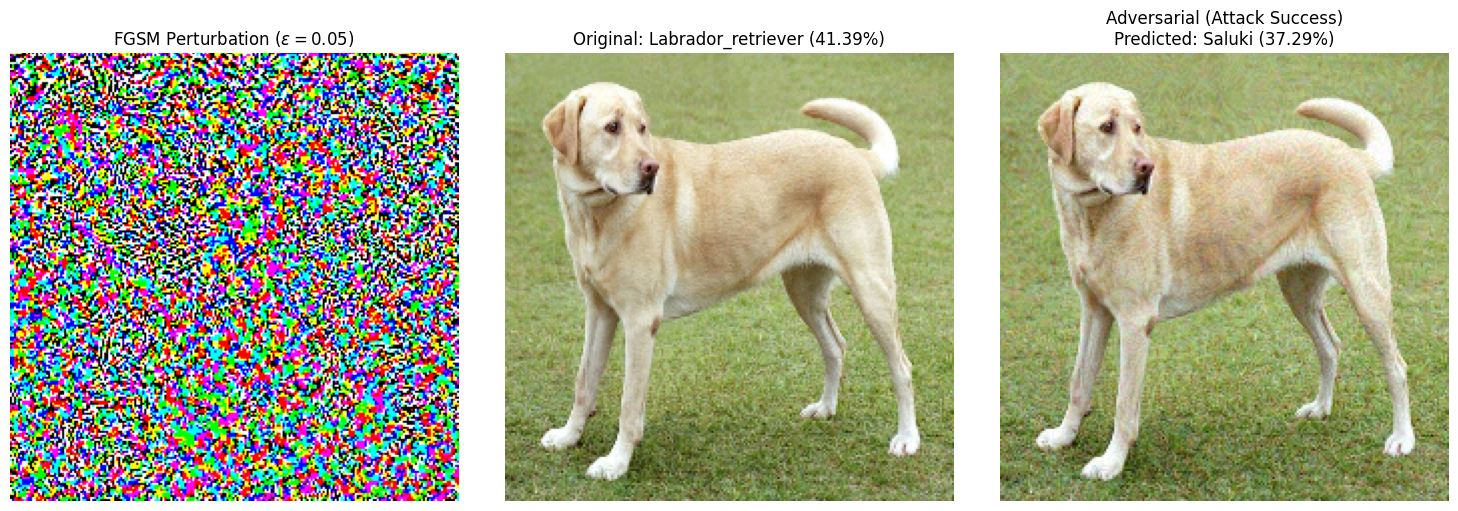


--- ATTACK REPORT (Epsilon = 0.05) ---
Original Prediction: Labrador_retriever (41.39%)
Adversarial Prediction: Saluki (37.29%)
Attack Result: SUCCESSFUL MISCLASSIFICATION
Vulnerability Demonstrated: Lack of Adversarial Robustness


In [9]:

# Epsilon (epsilon): Controls the magnitude of the perturbation.
# A value of 0.05 is generally imperceptible but effective.
epsilon = 0.05 
perturbations = create_adversarial_pattern(original_image, original_label)
adversarial_image = original_image + epsilon * perturbations

#  Clip the image values to maintain the valid MobileNetV2 range (-1 to 1)
adversarial_image = tf.clip_by_value(adversarial_image, -1.0, 1.0)

# Test the Adversarial Image 
adv_predictions = victim_model.predict(adversarial_image)

adv_decoded_predictions = decode_predictions(adv_predictions)
adv_label = adv_decoded_predictions[0][0][1]
adv_confidence = adv_decoded_predictions[0][0][2]
plt.figure(figsize=(15, 5))

def display_img(img_tensor, title, subplot_pos):
    plt.subplot(1, 3, subplot_pos)
    display_tensor = (img_tensor[0] + 1) / 2 
    plt.imshow(display_tensor)
    plt.title(title)
    plt.axis('off')

display_img(perturbations, f"FGSM Perturbation ($\epsilon={epsilon}$)", 1)

display_img(original_image, f"Original: {true_label} ({true_confidence*100:.2f}%)", 2)

display_img(adversarial_image, f"Adversarial (Attack Success)\nPredicted: {adv_label} ({adv_confidence*100:.2f}%)", 3)

plt.tight_layout()
plt.show()

print(f"\n--- ATTACK REPORT (Epsilon = {epsilon}) ---")
print(f"Original Prediction: {true_label} ({true_confidence*100:.2f}%)")
print(f"Adversarial Prediction: {adv_label} ({adv_confidence*100:.2f}%)")
print(f"Attack Result: {'SUCCESSFUL MISCLASSIFICATION' if true_label != adv_label else 'FAILURE'}")
print(f"Vulnerability Demonstrated: Lack of Adversarial Robustness")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


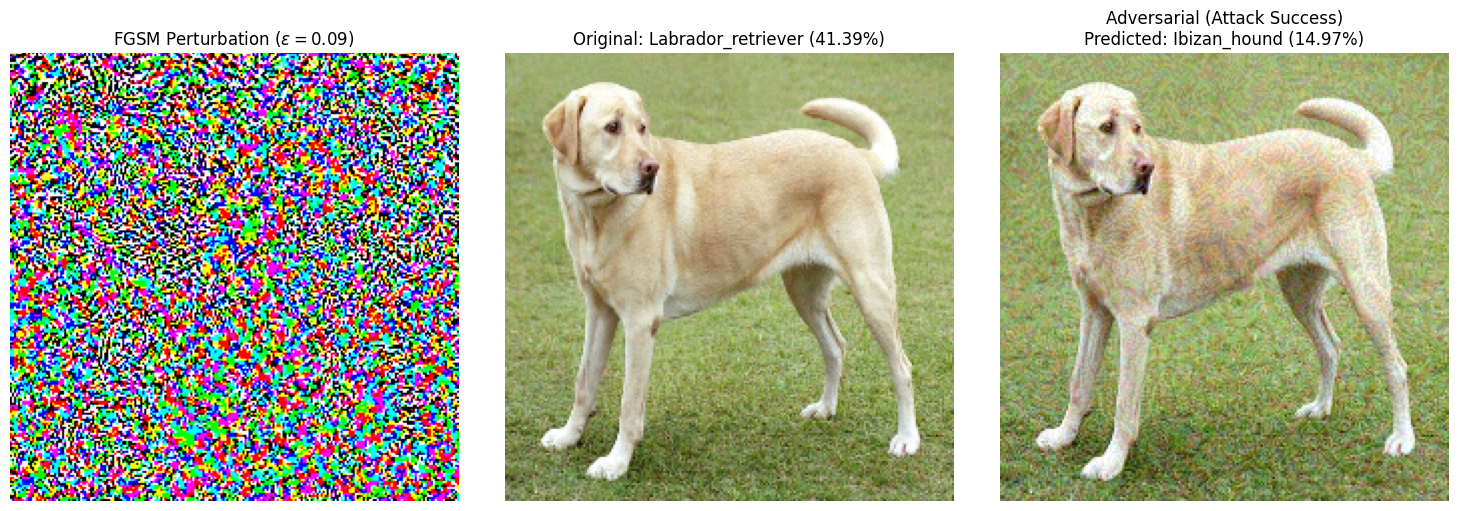


--- ATTACK REPORT (Epsilon = 0.09) ---
Original Prediction: Labrador_retriever (41.39%)
Adversarial Prediction: Ibizan_hound (14.97%)
Attack Result: SUCCESSFUL MISCLASSIFICATION
Vulnerability Demonstrated: Lack of Adversarial Robustness


In [14]:

epsilon = 0.09
perturbations = create_adversarial_pattern(original_image, original_label)

adversarial_image = original_image + epsilon * perturbations
adversarial_image = tf.clip_by_value(adversarial_image, -1.0, 1.0)
adv_predictions = victim_model.predict(adversarial_image)
adv_decoded_predictions = decode_predictions(adv_predictions)
adv_label = adv_decoded_predictions[0][0][1]
adv_confidence = adv_decoded_predictions[0][0][2]

plt.figure(figsize=(15, 5))

def display_img(img_tensor, title, subplot_pos):
    plt.subplot(1, 3, subplot_pos)
    display_tensor = (img_tensor[0] + 1) / 2 
    plt.imshow(display_tensor)
    plt.title(title)
    plt.axis('off')

# Plot 1: The Perturbation (Noise)
display_img(perturbations, f"FGSM Perturbation ($\epsilon={epsilon}$)", 1)

# Plot 2: The Original Image
display_img(original_image, f"Original: {true_label} ({true_confidence*100:.2f}%)", 2)

# Plot 3: The Adversarial Image
display_img(adversarial_image, f"Adversarial (Attack Success)\nPredicted: {adv_label} ({adv_confidence*100:.2f}%)", 3)

plt.tight_layout()
plt.show()

print(f"\n--- ATTACK REPORT (Epsilon = {epsilon}) ---")
print(f"Original Prediction: {true_label} ({true_confidence*100:.2f}%)")
print(f"Adversarial Prediction: {adv_label} ({adv_confidence*100:.2f}%)")
print(f"Attack Result: {'SUCCESSFUL MISCLASSIFICATION' if true_label != adv_label else 'FAILURE'}")
print(f"Vulnerability Demonstrated: Lack of Adversarial Robustness")